In [1]:
# Import Pandas and Numpy
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# Reading and creating directories
import os

# Ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings(action="ignore", message="credentials were not supplied. open data access only")

# Data Visualization libraries
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data
datafolder = r"C:\Users\alber\Statsbomb"
spadl_h5 = os.path.join(datafolder, "euro2020.h5")

# Load players data
with pd.HDFStore(spadl_h5) as spadlstore:
    
    # Get all players and teams of Euro2020
    games = spadlstore['games']
    teams = spadlstore['teams']

# Find number of games per team. First, we find the number of games played at home and away
home_games = games.groupby('home_team_id').count()
home_games.reset_index(inplace = True)
home_games = home_games[['home_team_id','game_id']]
away_games = games.groupby('away_team_id').count()
away_games.reset_index(inplace = True)
away_games = away_games[['away_team_id','game_id']]

# Merge home_games and away_games on team_id
team_games =home_games.merge(away_games, left_on = 'home_team_id', right_on = 'away_team_id')

# Find number of games per team
team_games['games_played'] = team_games.game_id_x+team_games.game_id_y
team_games['team_id'] = team_games.home_team_id

# Merge on teams to find teams' name
team_games = team_games[['team_id','games_played']].merge(teams)
    
# Load players that played at least 200 minutes
players = pd.read_csv('players.csv')

# Load all passes
passes = pd.read_csv('euro2020_passes.csv')

### Aggregate stats per player

In [3]:
# Find all player pass attempts and filter by player's minutes.
player_attempts = passes.groupby('player_name')[['type_name']].agg({'type_name':'count'})
player_attempts.reset_index(inplace = True)
player_attempts = player_attempts.merge(players, on = 'player_name')

# Rename columnso
player_attempts = player_attempts.rename(columns = {'type_name':'attempts'})


# Find all player successful passes and filter by player's minutes.
player_passes = passes[passes.result_name =='success'].groupby('player_name')[['type_name']].agg({'type_name':'count',})
player_passes.reset_index(inplace = True)
player_passes = player_passes.merge(players, on = 'player_name')

# Rename columns
player_passes = player_passes.rename(columns = {'type_name':'succ_passes'})

# Find all player successful line_breaking passes and filter by player's minutes.
player_lb = (passes[(passes.result_name =='success') & (passes.line_breaking == True)].
                 groupby('player_name')[['type_name']].agg({'type_name':'count',}))
player_lb.reset_index(inplace = True)
player_lb = player_lb.merge(players, on = 'player_name')

# Rename columns
player_lb = player_lb.rename(columns = {'type_name':'line_breaking_passes'})

# Merge all dataframes
players_agg = player_attempts.merge(player_passes).merge(player_lb)

# Add: line_breaking_pass per 90s, % of line_breaking_pass per pass,
players_agg['line_breaking_per_90s'] = round((players_agg.line_breaking_passes / players_agg.total_minutes)*90,2)
players_agg['perc_line_breaking_per_pass'] = round((players_agg.line_breaking_passes / players_agg.succ_passes)*100,2)

### Aggregate stats per team 

In [4]:
# Find all team pass attempts
team_attempts = passes.groupby('team_name')[['type_name',]].agg({'type_name':'count',})
team_attempts.reset_index(inplace = True)
team_attempts = team_attempts.merge(team_games, on = 'team_name')

# Rename columns
team_attempts = team_attempts.rename(columns = {'type_name':'attempts'})


# Find all team successful passes
team_passes = passes[passes.result_name =='success'].groupby('team_name')[['type_name']].agg({'type_name':'count'})
team_passes.reset_index(inplace = True)
pteam_passes = team_passes.merge(team_games, on = 'team_name')

# Rename columns
team_passes = team_passes.rename(columns = {'type_name':'succ_passes'})



# Find all team successful line_breaking passes and filter by player's minutes.
team_lb = (passes[(passes.result_name =='success') & (passes.line_breaking == True)].
                 groupby('team_name')[['type_name',]].agg({'type_name':'count'}))
team_lb.reset_index(inplace = True)
team_lb = team_lb.merge(team_games, on = 'team_name')

# Rename columns
team_lb = team_lb.rename(columns = {'type_name':'line_breaking_passes'})


# Merge all dataframes
teams_agg = team_attempts.merge(team_passes).merge(team_lb)

# Add: line_breaking_pass per game, % of line_breaking_pass per pass
teams_agg['line_breaking_per_game'] = round((teams_agg.line_breaking_passes / teams_agg.games_played),2)
teams_agg['perc_line_breaking_per_pass'] = round((teams_agg.line_breaking_passes / teams_agg.succ_passes)*100,2)

# Data Visualization


## Boxplot per roles

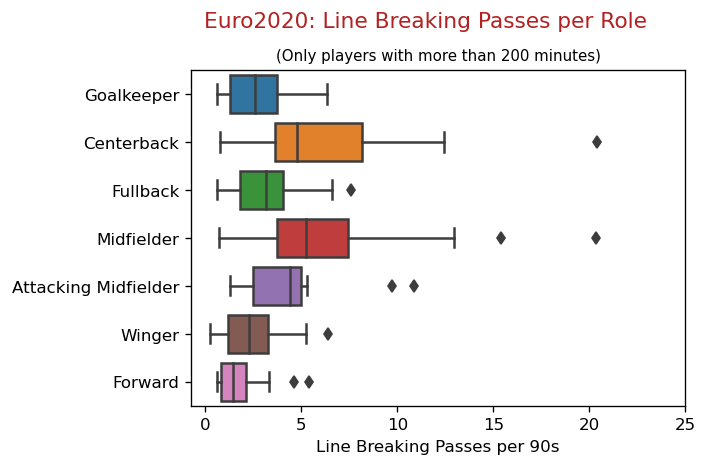

In [6]:
# Create the plot
fig,ax = plt.subplots()

# Plot the box plot ordered by roles
sns.boxplot(data = players_agg, y = 'most_common_role', x = 'line_breaking_per_90s', 
           order = ['Goalkeeper','Centerback','Fullback','Midfielder','Attacking Midfielder','Winger','Forward'])

# Set axis labels and ticks
ax.set_ylabel('')
ax.set_xlabel('Line Breaking Passes per 90s')
ax.set_xticks([k for k in range(0,30,5)])

# Make titles
plt.suptitle('Euro2020: Line Breaking Passes per Role', size = 13, color = 'firebrick',
             y = 0.96, x = 0.6)
plt.title('(Only players with more than 200 minutes)', size = 9, color = 'black',
             y = 1, x = 0.5)

# Tight layout for better visualization
fig.tight_layout()

# Show the plot
plt.show()

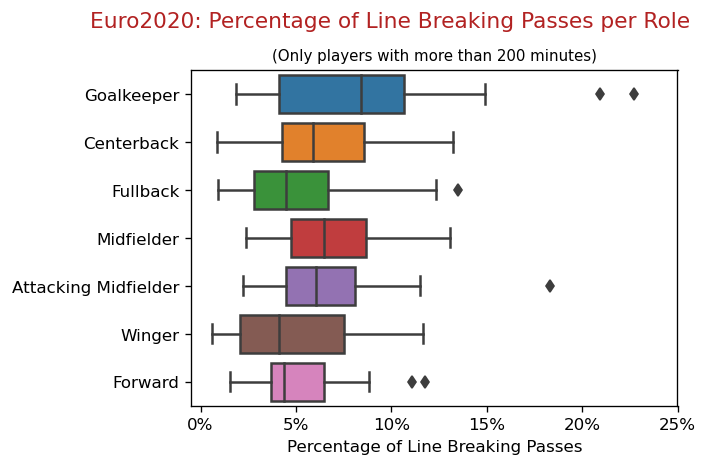

In [7]:
# Create the plot
fig,ax = plt.subplots()

# Plot the box plot ordered by roles
sns.boxplot(data = players_agg, y = 'most_common_role', x = 'perc_line_breaking_per_pass', 
           order = ['Goalkeeper','Centerback','Fullback','Midfielder','Attacking Midfielder','Winger','Forward'])

# Set axis labels and ticks
ax.set_ylabel('')
ax.set_xlabel('Percentage of Line Breaking Passes')
ax.set_xticks([k for k in range(0,30,5)])
ax.set_xticklabels([str(k)+'%' for k in range(0,30,5)])

# Make titles
plt.suptitle('Euro2020: Percentage of Line Breaking Passes per Role', size = 13, color = 'firebrick',
             y = 0.96, x = 0.55)
plt.title('(Only players with more than 200 minutes)', size = 9, color = 'black',
             y = 1, x = 0.5)

# Tight layout for better visualization
fig.tight_layout()

# Show the plot
plt.show()

## Standings for players and teams

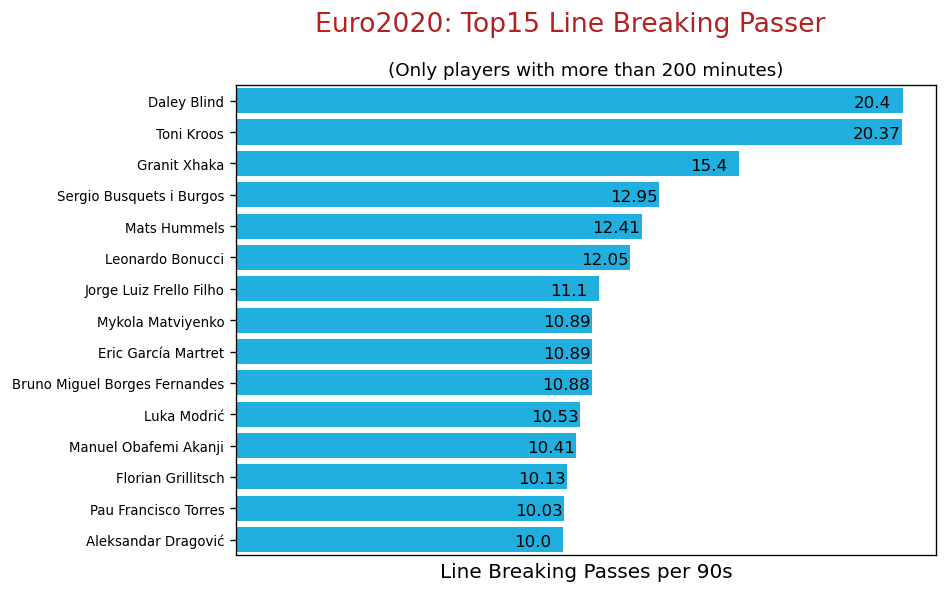

In [8]:
# Create the plot and choose figure size 
fig,ax = plt.subplots()
fig.set_size_inches(8,5)

# Find best 15 players
lb_best = players_agg.sort_values('line_breaking_per_90s', ascending = False).head(15).copy()
lb_best.reset_index(inplace = True)

# Plot the data: barplot for the top15
sns.barplot(data = lb_best,x ='line_breaking_per_90s' , y = 'player_name', color = 'deepskyblue', ax = ax)

# Set axis labels and ticks
ax.set_xlabel('Line Breaking Passes per 90s',size = 12)
ax.set_ylabel('',size = 9)
plt.yticks(fontsize=8)
plt.xticks([ ])

# Write the correspoding value for each bar
for index_val,x in zip(lb_best.index, lb_best['line_breaking_per_90s']):
    ax.annotate(str(x),(x-1.5, index_val +0.2),size = 10)


# Write titles
fig.suptitle('Euro2020: Top15 Line Breaking Passer',size = 16, x = 0.6, color = 'firebrick')
plt.title('(Only players with more than 200 minutes)',size = 11,ha = 'center')

# Tight layout for better visualization
fig.tight_layout()

# Show the plot
plt.show()

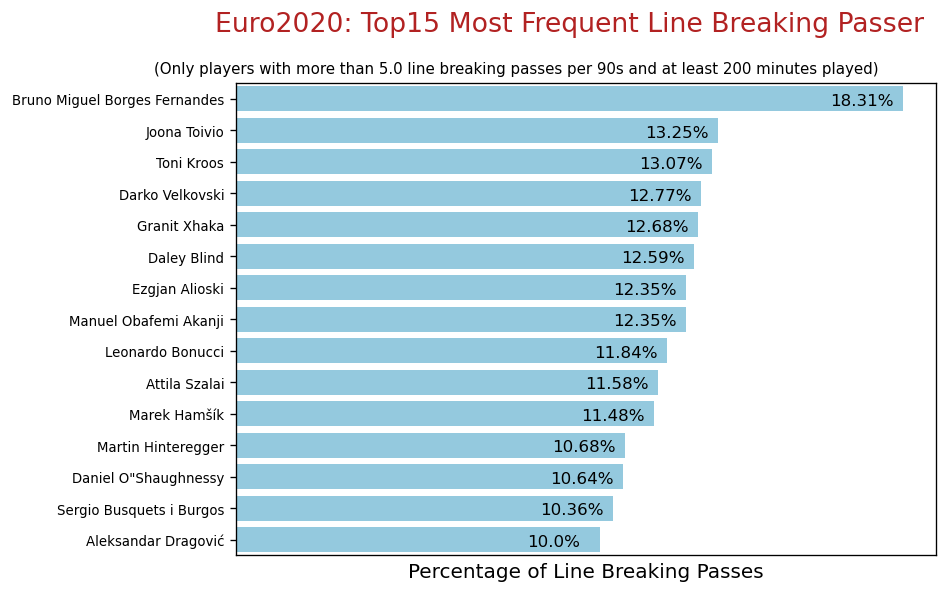

In [9]:
# Create the plot and choose figure size 
fig,ax = plt.subplots()
fig.set_size_inches(8,5)

# Find best 15 players and exclude GKs
lb_best_perc = (players_agg[(players_agg.most_common_role != 'Goalkeeper') & 
                            (players_agg.line_breaking_per_90s >5) ].
                sort_values('perc_line_breaking_per_pass', ascending = False).head(15).copy())
lb_best_perc.reset_index(inplace = True)

# Plot the data: barplot for the best15
sns.barplot(data = lb_best_perc,x ='perc_line_breaking_per_pass' , y = 'player_name', color = 'skyblue', ax = ax)

# Set axis labels and ticks
ax.set_xlabel('Percentage of Line Breaking Passes',size = 12)
ax.set_ylabel('',size = 9)
plt.yticks(fontsize=8)
plt.xticks([ ])

# Write the correspoding value for each bar
for index_val,x in zip(lb_best_perc.index, lb_best_perc['perc_line_breaking_per_pass']):
    ax.annotate(str(x)+'%',(x-2, index_val +0.2),size = 10)


# Titles
fig.suptitle('Euro2020: Top15 Most Frequent Line Breaking Passer',size = 16, x = 0.6, color = 'firebrick')
plt.title('(Only players with more than 5.0 line breaking passes per 90s and at least 200 minutes played)',size = 9,
         x = 0.4)

# Tight layout for better visualization
fig.tight_layout()

# Show the plot
plt.show()

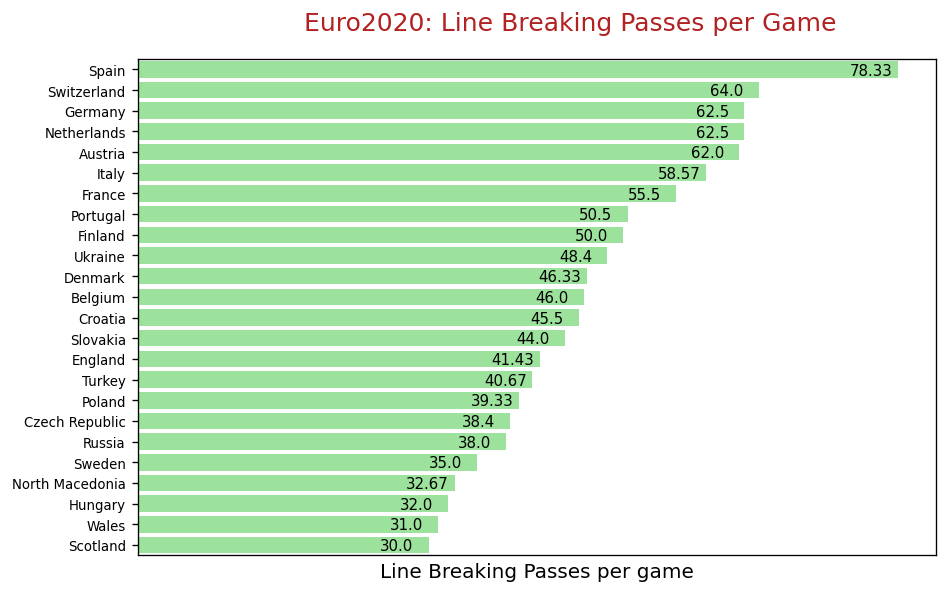

In [10]:
# Create the plot and choose figure size 
fig,ax = plt.subplots()
fig.set_size_inches(8,5)

# Order teams by line_breaking passes per games
tm_best = teams_agg.sort_values('line_breaking_per_game', ascending = False).copy()
tm_best.reset_index(inplace = True)

# Plot the data with a barplot
sns.barplot(data = tm_best,x ='line_breaking_per_game' , y = 'team_name', color = 'lightgreen', ax = ax)

# Set axis labels and ticks
ax.set_xlabel('Line Breaking Passes per game',size = 12)
ax.set_ylabel('',size = 9)
plt.yticks(fontsize=8)
plt.xticks([ ])

# Write the correspoding value for each bar
for index_val,x in zip(tm_best.index, tm_best['line_breaking_per_game']):
    ax.annotate(str(x),(x-5, index_val +0.25),size = 9)

# Titles
fig.suptitle('Euro2020: Line Breaking Passes per Game',size = 15, x = 0.6, color = 'firebrick')
fig.tight_layout()

# Show the plot
plt.show()

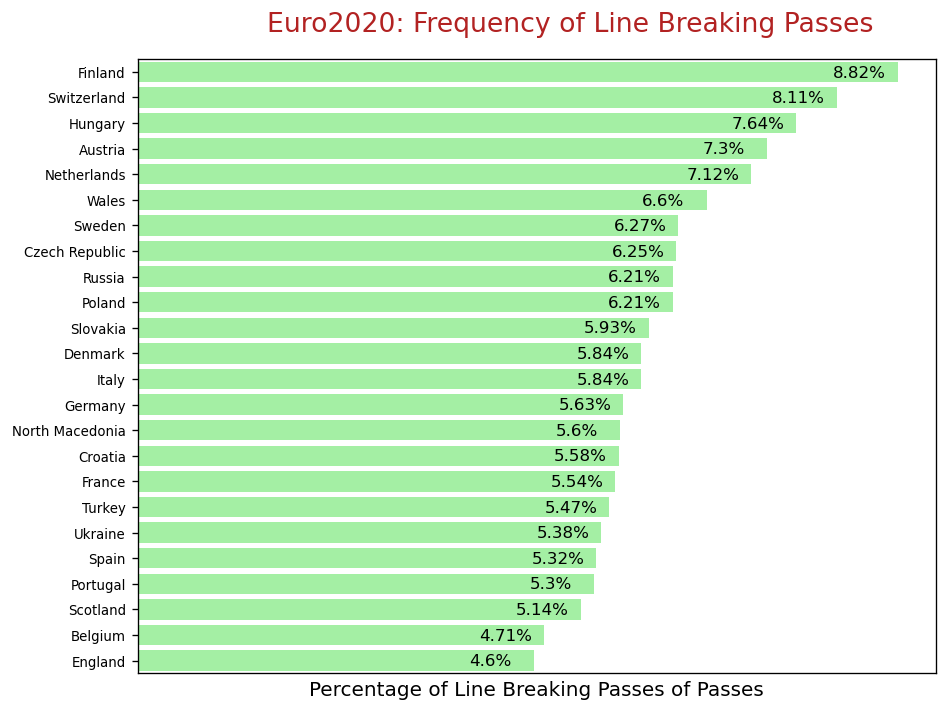

In [11]:
# Create the plot and choose figure size 
fig,ax = plt.subplots()
fig.set_size_inches(8,6)

# Order teams by percentage of line breaking pass
tm_best_perc = (teams_agg.sort_values('perc_line_breaking_per_pass', ascending = False).copy())
tm_best_perc.reset_index(inplace = True)

# Plot the data with a bar plot
sns.barplot(data = tm_best_perc,x ='perc_line_breaking_per_pass' , y = 'team_name', color = 'palegreen', ax = ax)

# Set axis labels and ticks
ax.set_xlabel('Percentage of Line Breaking Passes of Passes',size = 12)
ax.set_ylabel('',size = 9)
plt.yticks(fontsize=8)
plt.xticks([ ])

# Write the correspoding value for each bar
for index_val,x in zip(tm_best_perc.index,tm_best_perc['perc_line_breaking_per_pass']):
    ax.annotate(str(x)+'%',(x-0.75, index_val +0.2),size = 10)

# Make titles 
fig.suptitle('Euro2020: Frequency of Line Breaking Passes',size = 16, x = 0.6, color = 'firebrick')
fig.tight_layout()

# Show the plot
plt.show()